In [2]:
import numpy as np
from qutip import *
from scipy.interpolate import interp1d
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp, trapezoid
from tqdm import tqdm
import matplotlib.pyplot as plt
from qutip import basis, tensor, destroy, qeye, mesolve
import os

In [3]:
# ==============================================================================
# =============================================================================
# 1. CARGA Y SELECCIÓN DE CANDIDATO
# =============================================================================

nombre_archivo = "candidatos_negativos_todos.npy"

try:
    # Cargamos la lista completa. Al ser una lista de dicts, usamos .tolist() si numpy lo envolvió
    lista_candidatos = np.load(nombre_archivo, allow_pickle=True)
    
    # ---------------------------------------------------------
    # CONFIGURACIÓN DE USUARIO: ELIGE AQUÍ TU CANDIDATO
    # ---------------------------------------------------------
    # Cambia este número por el ID (índice) que prefieras de la lista impresa abajo
    INDICE_SELECCIONADO = 0  
    # ---------------------------------------------------------

    print(f"Se cargaron {len(lista_candidatos)} candidatos con Q negativo.")
    print("-" * 60)
    print(f"{'ID':<5} | {'Q Mandel':<10} | {'r':<10} | {'theta (rad)':<12}")
    print("-" * 60)
    
    # Imprimimos los primeros 15 para que elijas (o todos si son pocos)
    muestras = min(len(lista_candidatos), 700)
    for idx in range(muestras):
        c = lista_candidatos[idx]
        marcador = "<-- SELECCIONADO" if idx == INDICE_SELECCIONADO else ""
        print(f"{idx:<5} | {c['q_mandel']:<10.4f} | {c['r']:<10.4f} | {c['theta']:<12.4f} {marcador}")
    
    if len(lista_candidatos) > 20:
        print(f"... y {len(lista_candidatos) - 20} más.")
    print("-" * 60)

    # Obtenemos los datos del elegido
    seleccion = lista_candidatos[INDICE_SELECCIONADO]
    alpha_sel = seleccion['alpha_val']
    xi_sel = seleccion['xi_val']
    q_sel = seleccion['q_mandel']

    print(f"\nUsando candidato ID {INDICE_SELECCIONADO}:")
    print(f"  Q = {q_sel:.4f}")
    print(f"  alpha = {alpha_sel:.4f}")
    print(f"  xi    = {xi_sel:.4f}")

except FileNotFoundError:
    raise FileNotFoundError("Error: No existe el archivo .npy. Ejecuta el Script 1 primero.")
except IndexError:
    raise IndexError(f"Error: El índice {INDICE_SELECCIONADO} no existe en la lista de candidatos.")


# =============================================================================
# 2. CÁLCULO DE VALORES ESPERADOS (r_a, r_ad, etc.)
# =============================================================================

# Parámetros del sistema
N_osc = 60
a = destroy(N_osc)
adag = create(N_osc)
num_op = num(N_osc)

# Reconstruimos el estado psi específico para este candidato
psi_input = displace(N_osc, alpha_sel) * squeeze(N_osc, xi_sel) * basis(N_osc, 0)

# Definimos las variables para el resto de tu código
r_a   = expect(a, psi_input)
r_ad  = expect(adag, psi_input)
r_ada = expect(num_op, psi_input)      # Este es <N>
r_a2  = expect(a**2, psi_input)
r_ad2 = expect(adag**2, psi_input)
r_N2  = expect(num_op**2, psi_input)

print("\nVariables calculadas e inicializadas:")
print(f"  r_a   = {r_a:.4f}")
print(f"  r_ada (<N>) = {r_ada:.4f}")
print(f"  r_a2  = {r_a2:.4f}")
print(f"  r_ad2 = {r_ad2:.4f}")
print(f"  r_N2  = {r_N2:.4f}")  

#El factor de Mandel se calcula como
q_mandel = (r_N2 - r_ada**2) / r_ada - 1
print(f"  Q Mandel recalculado = {q_mandel:.4f}")


Se cargaron 720 candidatos con Q negativo.
------------------------------------------------------------
ID    | Q Mandel   | r          | theta (rad) 
------------------------------------------------------------
0     | -0.0696    | 0.0366     | 0.0383       <-- SELECCIONADO
1     | -0.1322    | 0.0732     | 0.0383       
2     | -0.1877    | 0.1098     | 0.0383       
3     | -0.2361    | 0.1463     | 0.0383       
4     | -0.2773    | 0.1829     | 0.0383       
5     | -0.3112    | 0.2195     | 0.0383       
6     | -0.3377    | 0.2561     | 0.0383       
7     | -0.3566    | 0.2927     | 0.0383       
8     | -0.3678    | 0.3293     | 0.0383       
9     | -0.3711    | 0.3659     | 0.0383       
10    | -0.3661    | 0.4024     | 0.0383       
11    | -0.3525    | 0.4390     | 0.0383       
12    | -0.3301    | 0.4756     | 0.0383       
13    | -0.2985    | 0.5122     | 0.0383       
14    | -0.2571    | 0.5488     | 0.0383       
15    | -0.2055    | 0.5854     | 0.0383       
16  

In [12]:
# ======================================================================
#                     FUNCIÓN PRINCIPAL DE SIMULACIÓN
# ======================================================================
d1 = 0.025
d2 = 0.00026
au_cm1 = 2.1947463137e5
au_fs = 0.02418884326505

def realizar_simulacion_y_optimización(t_final_fs, omega_c_valor, omega_0base, carpeta_salida, f0_initial_factor, kappa_factor, Ub_factor, iteraciones, tau=0.0001):

    """
    Realiza una corrida completa de optimización y simulación con QuTiP para un conjunto

    dado de parámetros y guarda los gráficos resultantes.

    """

    # --- 1. CONFIGURACIÓN DE PARÁMETROS PARA ESTA ITERACIÓN ---
    omega_0 = omega_0base
    omega_c = omega_c_valor
    E0 = 2.0 * omega_c
    U_b = Ub_factor * omega_c 
    kappa = kappa_factor * omega_c  
    t_final = t_final_fs / au_fs
    t_span = (0, t_final)
    num_steps = 7000
    t_eval = np.linspace(t_span[0], t_final, num_steps)
    dt = t_eval[1] - t_eval[0]
    max_iter = iteraciones
    R = 1.0
    f0_initial = f0_initial_factor * omega_c


    # --- 2. DEFINICIÓN DE FUNCIONES Y ECUACIONES ---


    def create_interpolator(t, values):
        return interp1d(t, values, kind='linear', bounds_error=False, fill_value="extrapolate")


   # ==============================================================================
    # Sistema de 14 Ecuaciones para el Hamiltoniano con Expansión Dipolar (FME)
    # ==============================================================================

    # Orden del vector de estado y:
    # 0:⟨a†a⟩, 1:⟨b†b⟩, 2:⟨a⟩, 3:⟨a†⟩, 4:⟨b⟩, 5:⟨b†⟩, 6:⟨ab†⟩, 7:⟨a†b†⟩,
    # 8:⟨a†b⟩, 9:⟨ab⟩, 10:⟨a²⟩, 11:⟨a†²⟩, 12:⟨b²⟩, 13:⟨b†²⟩, 14:⟨a†aa†a⟩

    def system_equations(t, y_states, f_interp):
        # --- 1. Desempaquetar el vector de estado ---
        A, B, C, D, E, F, G, H, I, J, K, L, M, N, O = y_states
        ft = f_interp(t).real
        x_a = D + C  # ⟨a†⟩ + ⟨a⟩


        # Aproximaciones de momentos de orden 3
        approx_b_dag_b_sq = 2*B*E + F*M - 2*F*E**2
        approx_b_dag_sq_b = 2*B*F + N*E - 2*E*F**2
        approx_b_dag_b_cubed = -2*F*E**3 + 3*B*M
        approx_b_dag_cubed_b = np.conjugate(approx_b_dag_b_cubed)
        approx_a_dag_b_dag_sq_b = 2*H*B + I*N - 2*D*E*F**2 
        approx_a_b_dag_b_sq = np.conjugate(approx_a_dag_b_dag_sq_b)
        approx_a_dag_b_dag_b_sq = 2*I*B + H*M - 2*D*F*E**2
        approx_a_b_dag_sq_b = np.conjugate(approx_a_dag_b_dag_b_sq)
        #Aproximaciones de momentos de orden 4
        approx_a_dag_b_dag_sq = D*N + 2*F*H - 2*D*F**2
        approx_a_dag_b_dag_b = D*B + F*I + E*H - 2*D*F*E
        approx_a_dag_b_sq = D*M + 2*E*I - 2*D*E**2
        approx_a_b_dag_sq = C*N + 2*F*G - 2*C*F**2
        approx_a_b_dag_b = C*B + F*J + E*G - 2*C*F*E
        approx_a_b_sq = C*M + 2*E*J - 2*C*E**2
        term_d2_a_pop = E0*d2*(approx_a_dag_b_dag_sq + 2*approx_a_dag_b_dag_b + approx_a_dag_b_sq + D - (approx_a_b_dag_sq + 2*approx_a_b_dag_b + approx_a_b_sq + C))
        dA_dt = -1j * (E0*d1 * (H + I - G - J) + term_d2_a_pop +ft*(D - C)) -kappa * A #Ecuación para d⟨a†a⟩/dt

        term_d2_b_pop = 2*E0*d2*(approx_a_dag_b_dag_sq - approx_a_dag_b_sq + approx_a_b_dag_sq - approx_a_b_sq)
        dB_dt = -1j * (E0*d1 * (H - I + G - J) + term_d2_b_pop) # Ecuación para d⟨b†b⟩/dt

        dC_dt = -1j * (omega_c * C + E0*d1 * (F + E) + E0 * d2 * (N + 2*B + M + 1) +ft) -(kappa/2) * C # Ecuación para d⟨a⟩/dt

        dD_dt = np.conjugate(dC_dt) # Ecuación para d⟨a†⟩/dt

        dE_dt = -1j * (omega_0 * E - 2*U_b*approx_b_dag_b_sq + E0*d1*x_a + 2*E0*d2*(G + J + H + I)) # Ecuación para d⟨b⟩/dt

        dF_dt = np.conjugate(dE_dt) # Ecuación para d⟨b†⟩/dt

        dK_dt = -2j * (omega_c * K + E0*d1*(G + J) + E0*d2*(approx_a_b_dag_sq + 2*approx_a_b_dag_b + approx_a_b_sq + C)  +ft*C) -kappa * K # Ecuación para d⟨a²⟩/dt

        dL_dt = np.conjugate(dK_dt) # Ecuación para d⟨a†²⟩/dt

        dM_dt = -2j * (omega_0*M - U_b*(2*approx_b_dag_b_cubed + M) + E0 * d1*(I + J) + E0*d2*(2*approx_a_dag_b_dag_b + D + 2*approx_a_dag_b_sq + 2*approx_a_b_dag_b + C + 2*approx_a_b_sq)) # Ecuación para d⟨b²⟩/dt

        dN_dt = np.conjugate(dM_dt) # Ecuación para d⟨b†²⟩/dt

        

        # Cumulantes para términos cruzados
        approx_a_dag_a_b = D*J + C*I + E*A - 2*D*C*E
        approx_a_dag_a_b_dag = D*G + C*H + F*A - 2*D*C*F
        approx_a_sq_b = 2*C*J + E*K - 2*C**2*E
        approx_a_sq_b_dag = 2*C*G + F*K - 2*C**2*F
        approx_b_cubed = 3*E*M - 2*E**3
        approx_b_b_dag_b = (2*E*B + F*M - 2*E**2*F) + E
        approx_b_b_dag_sq = (2*F*B + E*N - 2*F**2*E) + 2*F

        term_d2_ab = E0*d2*(2*(approx_a_dag_a_b + approx_a_dag_a_b_dag + approx_a_sq_b + approx_a_sq_b_dag) + approx_b_cubed + 2*approx_b_b_dag_b + approx_b_b_dag_sq + E)

        dJ_dt = -1j * ((omega_c+omega_0)*J - 2*U_b*approx_a_b_dag_b_sq + E0*d1*(A+K+B+M+1) + term_d2_ab +ft*E) -(kappa/2) * J # Ecuación para d⟨ab⟩/dt

        dH_dt = np.conjugate(dJ_dt) # Ecuación para d⟨a†b†⟩/dt

        
        # Más cumulantes para términos cruzados
        approx_b_dag_cubed = 3*F*N - 2*F**3
        approx_b_dag_b_b_dag = (2*F*B + E*N - 2*F**2*E) + F
        approx_b_sq_b_dag = 2*E*B + 2*E + F*M - 2*E**2*F
        approx_a_a_dag_b_dag = approx_a_dag_a_b_dag + F
        approx_a_a_dag_b = approx_a_dag_a_b + E

        term_d2_ab_dag = E0*d2*(approx_b_dag_cubed + 2*approx_b_dag_b_b_dag + approx_b_sq_b_dag + F - 2*(approx_a_sq_b_dag + approx_a_sq_b + approx_a_a_dag_b_dag + approx_a_a_dag_b))

        dG_dt = -1j * ((omega_c-omega_0)*G + 2*U_b*approx_a_b_dag_sq_b - E0*d1*(A+K-B-N) + term_d2_ab_dag +ft*F) -(kappa/2) * G # Ecuación para d⟨a†b⟩/dt

        dI_dt = np.conjugate(dG_dt) # Ecuación para d⟨ab†⟩/dt


        # dO/dt = d<a†aa†a>/dt

        term1_f = ft * ( (A + 1)*D + 3*D*A )
        term2_g = E0*d1 * ( 2*G*L + (A+1)*I + 3*A*I + \
                        (A+1)*H + 3*A*H - (A+1)*J - (A+1)*G - 3*J*A - 3*G*A + \
                        2*J*L )
        term3 = -2*K * ( ft*D + E0*d1*(I + H) )
        term4 = 4*(C**2)*D * ( ft + E0*d1*(E+F) )
        term5 = -C * ( (A+1 + 3*A - 2*L)*ft + 4*(D**2)*(ft + (E+F)*E0*d1) )

        #Cumulantes para términos con d2
        approx_N_a_dag_b_dag_sq = approx_a_b_dag_sq * L + approx_a_dag_b_dag_sq * (2*A + 1) - 2 * C * N * D**2
        approx_N_a_dag_b_dag_b = approx_a_b_dag_b * L + approx_a_dag_b_dag_b * (2*A + 1) - 2 * C * B * D**2
        approx_N_a_dag_b_sq = approx_a_b_sq * L + approx_a_dag_b_sq * (2*A + 1) - 2 * C * M * D**2
        approx_a_dag_a_a_dag = (A + 1) * D - 2 * C * D**2 + D * A + C * L
        approx_N_a_b_sq = 2 * approx_a_b_sq * A + K * approx_a_dag_b_sq - 2 * C**2 * M * D
        approx_a_dag_N_b_dag_sq = np.conjugate(approx_N_a_b_sq) # <a† a†a b†b†>
        approx_N_a_b_dag_b = 2 * approx_a_b_dag_b * A + K * approx_a_dag_b_dag_b - 2 * C**2 * B * D
        approx_a_dag_N_b_dag_b = np.conjugate(approx_N_a_b_dag_b)     # <a† a†a b†b>
        approx_N_a_b_dag_sq = 2 * approx_a_b_dag_sq * A + K * approx_a_dag_b_dag_sq - 2 * C**2 * N * D
        approx_a_dag_N_b_sq  = np.conjugate(approx_N_a_b_dag_sq)    # <a† a†a b b>
        approx_a_dag_sq_a = -2 * C * D**2 + 2 * D * A + C * L
        d_N_sq_term_d2_pos = E0 * d2 * (
            approx_N_a_dag_b_dag_sq + 2 * approx_N_a_dag_b_dag_b + approx_N_a_dag_b_sq +
            approx_a_dag_a_a_dag +  # Este es <N a†>
            approx_a_dag_N_b_dag_sq + 2 * approx_a_dag_N_b_dag_b + approx_a_dag_N_b_sq +
            approx_a_dag_sq_a      # Este es <a† N>
        )

        

        # Parte "negativa" (con a)
        # <N a b†²> + 2<N a b†b> + <N a b²> + <N a> +
        # <a N b†²> + 2<a N b†b> + <a N b²> + <a N>
        approx_a_dag_a_a = -2 * C**2 * D + K * D + 2 * C * A
        approx_a_N_b_dag_sq = np.conjugate(approx_N_a_dag_b_sq) 
        approx_a_N_b_dag_b = np.conjugate(approx_N_a_dag_b_dag_b)
        approx_a_N_b_sq = np.conjugate(approx_N_a_dag_b_dag_sq) 
        approx_a_a_dag_a = C * (A + 1) - 2 * C**2 * D + K * D + C * A
        d_N_sq_term_d2_neg = E0 * d2 * (
            approx_N_a_b_dag_sq + 2 * approx_N_a_b_dag_b + approx_N_a_b_sq +
            approx_a_dag_a_a +      # Este es <N a>
            approx_a_N_b_dag_sq + 2 * approx_a_N_b_dag_b + approx_a_N_b_sq +
            approx_a_a_dag_a        # Este es <a N>
        )
        d_N_sq_term_d2 = d_N_sq_term_d2_pos - d_N_sq_term_d2_neg

        dO_dt = -1j * (term1_f + term2_g + term3 + term4 + term5 + d_N_sq_term_d2) + kappa*(-2* O+A) # Ecuación para d⟨a†aa†a⟩/dt


        return np.array([dA_dt, dB_dt, dC_dt, dD_dt, dE_dt, dF_dt, dG_dt, dH_dt,
                        dI_dt, dJ_dt, dK_dt, dL_dt, dM_dt, dN_dt, dO_dt], dtype=complex)


    # ==============================================================================

    # Orden del vector de coestado p:
    # 0:P⟨a†a⟩, 1:P⟨b†b⟩, 2:P⟨a⟩, 3:P⟨a†⟩, 4:P⟨b⟩, 5:P⟨b†⟩, 6:P⟨ab†⟩, 7:P⟨a†b†⟩,
    # 8:P⟨a†b⟩, 9:P⟨ab⟩, 10:P⟨a²⟩, 11:P⟨a†²⟩, 12:P⟨b²⟩, 13:P⟨b†²⟩, 14:P⟨a†aa†a⟩
    #Función de interpolación manual de estados
    def iterpolator_manual(sol_ivp):
        state_interpolators = [interp1d(sol_ivp.t, sol_ivp.y[i], kind='cubic', bounds_error=False, fill_value="extrapolate") for i in range(14)]
        return state_interpolators

    #Función para obtener los estados en tiempo t dado un conjunto de interpoladores
    def get_states_at_t(t, state_interpolators):
        return np.array([interp(t) for interp in state_interpolators])

    def costate_equations(t, p, x_interp , f_interp):
        # --- A. Desempaquetar vector de coestados (Dimensión 15) ---
        # Se añade P_adaada al final
        Ub = U_b
        x = x_interp(t)
        (P_ada, P_bdb, P_a, P_ad, P_b, P_bd, P_abd, P_adbd,
        P_adb, P_ab, P_a2, P_ad2, P_b2, P_bd2, P_adaada) = p

        # --- B. Obtener los estados en el tiempo t ---
        (ada, bdb, a, ad, b, bd,
        abd, adbd, adb, ab,
        a2, ad2, b2, bd2, n2) = x
        
        # Variables auxiliares derivadas
        aad = ada + 1.0 + 0j
        ft = f_interp(t).real # Pulso de control f(t)

        # Pre-cálculos de términos comunes
        b_plus_bd = b + bd
        b_sq_terms = b2 + 2*bdb + bd2 # (b + bd)^2 expandido en operadores
        b_plus_bd_sq_val = b_plus_bd**2 # Valor numérico de (<b+bd>)^2

        # Bloque polinómico común de d2 que aparece en varias ecuaciones:
        # 1 + 2(<b+bd>)^2 + 4(<b^2> + 2<b†b> + <b†^2>)
        poly_d2_common = 1.0 + 2.0 * b_plus_bd_sq_val + 4.0 * b_sq_terms
        
        # Bloque común para f(t) + E0*d2*(...)
        term_forcing = ft + E0 * d2 * poly_d2_common

        # --------------------------------------------------------------------------
        # 1. dP_⟨a†a⟩/dt
        # --------------------------------------------------------------------------
        # Termino kappa
        dP_ada_dt_kappa = kappa * (P_ada - P_adaada)
        
        # Termino d1
        term1_d1 = E0 * d1 * (P_abd + P_adbd - P_ab - P_adb)
        
        # Termino d2 (linear in b)
        term1_d2_lin = 2.0 * E0 * d2 * (bd - b) * (P_adbd - P_ab)
        
        # Termino P_adaada (Line 3 and 4 of LaTeX)
        term1_P4_A = 4.0 * P_adaada * (E0 * d1 + 6.0 * E0 * d2 * (bd - b)) * (ab + abd - adb - adbd)
        term1_P4_B = P_adaada * (a - ad) * (4.0 * ft + 3.0 * E0 * d2 * poly_d2_common)
        
        # Terminos finales (Lines 5 and 6)
        term1_rest_A = -2.0j * E0 * d2 * b_plus_bd * (P_abd - P_adb)
        term1_rest_B = 1j * E0 * d2 * P_adaada * (
            (ad - a) * (1.0 - 4.0 * b_plus_bd_sq_val + 4.0 * b_sq_terms) -
            8.0 * b_plus_bd * (ab + abd - adb - adbd)
        )

        dP_ada_dt = dP_ada_dt_kappa - 1j * (term1_d1 + term1_d2_lin + term1_P4_A + term1_P4_B) + term1_rest_A + term1_rest_B


        # --------------------------------------------------------------------------
        # 2. dP_⟨a†⟩/dt
        # --------------------------------------------------------------------------
        
        term2_L1 = (kappa / 2.0 - 1j * omega_c) * P_ad + 1j * E0 * d1 * (P_b - P_bd)
        
        poly_d2_ad = 1.0 + 2.0 * b_sq_terms - 4.0 * b_plus_bd_sq_val
        term_forcing_ad = ft + E0 * d2 * poly_d2_ad
        
        term2_L2 = 1j * term_forcing_ad * (P_ada - 2.0 * P_ad2)
        
        term2_L3 = -2.0j * E0 * d2 * poly_d2_ad * (P_b2 - P_bd2)
        
        term2_L4 = -2.0j * E0 * d2 * (
            b**2 * (P_ab - P_adb) +
            bd**2 * (P_abd - P_adbd) +
            2.0 * b * bd * (P_abd + P_adb - P_ab - P_adbd)
        )

        term2_L5 = 4.0j * Ub * b * bd * (b * P_adb - bd * P_adbd)
        
        poly_state_ad = 1.0 - 2.0 * (a2 - 2.0 * a**2) + 4.0 * (ada - 2.0 * ad * a)
    
        term_forcing_P4 = ft + E0 * d1 * b_plus_bd + E0 * d2 * poly_d2_ad
        
        term2_L6 = 1j * P_adaada * poly_state_ad * term_forcing_P4
        
        dP_ad_dt = term2_L1 + term2_L2 + term2_L3 + term2_L4 + term2_L5 + term2_L6


        # --------------------------------------------------------------------------
        # 3. dP_⟨a⟩/dt (Conjugado)
        # --------------------------------------------------------------------------
        dP_a_dt = np.conjugate(dP_ad_dt)


        # --------------------------------------------------------------------------
        # 4. dP_⟨a†2⟩/dt
        # --------------------------------------------------------------------------
        term4_L1 = -1j * (2.0 * omega_c * P_ad2 + (E0 * d1 + 2.0 * E0 * d2 * b_plus_bd) * (P_adbd - P_adb))
        
        term4_L2 = 2.0j * P_adaada * (
            E0 * (d1 + 8.0 * d2 * b_plus_bd) * (ab + abd) +
            a * term_forcing
        )
        
        dP_ad2_dt = term4_L1 + term4_L2 + kappa * P_ad2


        # --------------------------------------------------------------------------
        # 5. dP_⟨a2⟩/dt (Conjugado)
        # --------------------------------------------------------------------------
        dP_a2_dt = np.conjugate(dP_ad2_dt)


        # --------------------------------------------------------------------------
        # 6. dP_⟨b†b⟩/dt
        # --------------------------------------------------------------------------
        term6_L1 = 1j * E0 * d1 * (ab + abd - adb - adbd)
        
        term6_L2 = 2.0j * E0 * d2 * (
            (P_a - P_ad) + 
            b * (P_ab - P_adb) + 
            bd * (P_abd - P_adbd)
        )
        
        term6_L3 = 2.0j * E0 * d2 * (
            ad * P_ada - 2.0 * ad * P_ad2 +
            a * (2.0 * P_a2 - P_ada) +
            2.0 * (ad + a) * (P_b2 - P_bd2)
        )
        
        term6_L4_state = ad * (2.0 * a**2 - 2.0 * a2 + aad + 3.0 * ada) - a * (aad + 2.0 * ad**2 + 3.0 * ada - 2.0 * ad2)
        term6_L4 = 4.0j * E0 * d2 * P_adaada * term6_L4_state
        
        term6_L5 = -4.0j * Ub * (
            b * P_b - bd * P_bd +
            3.0 * b2 * P_b2 - 3.0 * bd2 * P_bd2 +
            ab * P_ab - abd * P_abd +
            adb * P_adb - adbd * P_adbd
        )
        
        dP_bdb_dt = term6_L1 + term6_L2 + term6_L3 + term6_L4 + term6_L5


        # --------------------------------------------------------------------------
        # 7. dP_⟨b⟩/dt
        # --------------------------------------------------------------------------
        # Term 1: P_b
        term7_Pb = 1j * (omega_0 + 4.0 * Ub * (2.0 * b * bd - bdb)) * P_b
        
        # Term 2: P_a - P_ad
        term7_Pa = 1j * E0 * d1 * (P_a - P_ad)
        
        # Common poly for P_ab and P_adb in Eq 7
        # 1 - 4<a ad> + 2<aad> + 2<ada> - 4<a>^2 + 2<a2>
        poly_state_b = 1.0 - 4.0 * a * ad + 2.0 * aad + 2.0 * ada - 4.0 * a**2 + 2.0 * a2
        # -6<b>^2 + 3<b2> - 8<b bd> + 2<bdb> + 2<bbd> - 2<bd>^2 + <bd2> (Note: <bbd> is bdb usually, context implies b b dagger?)
        # Assuming standard ordering: <b b†> = <b† b> + 1 = bdb + 1
        bbd = bdb + 1.0
        poly_b_state = -6.0 * b**2 + 3.0 * b2 - 8.0 * b * bd + 2.0 * bdb + 2.0 * bbd - 2.0 * bd**2 + bd2
        
        bracket_common = ft + E0 * d2 * poly_state_b + E0 * d2 * poly_b_state
        
        # Term 3: P_ab
        term7_Pab = 1j * (bracket_common + 8.0 * Ub * a * b * bd) * P_ab
        
        # Term 4: P_adb
        term7_Padb = -1j * (bracket_common - 8.0 * Ub * ad * b * bd) * P_adb
        
        # Term 5: P_abd (Line 5)
        term7_Pabd = 1j * (
            E0 * d2 * (4.0*a*ad - 2.0*aad - 2.0*ada + 4.0*a**2 - 2.0*a2 + 4.0*bd**2 - 2.0*bd2) -
            4.0 * Ub * a * bd**2
        ) * P_abd
        
        # Term 6: P_adbd (Line 6)
        term7_Padbd = 1j * (
            E0 * d2 * (4.0*a*ad + 4.0*ad**2 - 2.0*ada - 2.0*ad2 + 4.0*bd**2 - 2.0*bd2) -
            4.0 * Ub * ad * bd**2
        ) * P_adbd
        
        # Term 7: P_a2
        term7_Pa2 = -4.0j * E0 * d2 * (ab + abd) * P_a2
        
        # Term 8: P_ada
        term7_Pada = 2.0j * E0 * d2 * (adb + adbd - abd - ab + 2.0 * b_plus_bd * (a - ad)) * P_ada
        
        # Term 9: P_ad2
        term7_Pad2 = 4.0j * E0 * d2 * (2.0 * ad * b_plus_bd - adb - adbd) * P_ad2
        
        # Term 10: P_b2
        term7_Pb2 = 1j * (
            E0 * d2 * (4.0*abd + 8.0*adb + 4.0*adbd - 16.0*a*b - 16.0*ad*b - 8.0*a*bd - 8.0*ad*bd - 4.0*ab) +
            24.0 * Ub * b**2 * bd
        ) * P_b2
        
        # Term 11: P_bdb
        term7_Pbdb = 1j * (
            E0 * d2 * (2.0*ab - 4.0*adb + 8.0*a*b + 8.0*ad*b) -
            4.0 * Ub * bd * (bdb - 2.0 * b * bd)
        ) * P_bdb
        
        # Term 12: P_bd2
        term7_Pbd2 = 1j * (
            E0 * d2 * (8.0*a*bd + 8.0*ad*bd - 4.0*abd - 4.0*adbd) -
            8.0 * Ub * bd**3
        ) * P_bd2
        
        # Term 13: P_adaada (Massive block)
        # Line 1
        t_P4_1 = 4.0 * E0 * d1 * a * ada * (a - ad)
        # Line 2
        t_P4_2 = 8.0 * E0 * d2 * (ab + abd) * (4.0*a*ad - aad - 3.0*ada - 2.0*ad**2 + 2.0*ad2)
        # Line 3
        t_P4_3 = 8.0 * E0 * d2 * (adb + adbd) * (2.0*a**2 - 2.0*a2 + aad - 4.0*a*ad + 3.0*ada)
        # Line 4 & 5
        t_P4_4 = 8.0 * E0 * d2 * b_plus_bd * (
            8.0*a*aad - 24.0*a**2*ad + 16.0*a2*ad - 8.0*aad*ad +
            24.0*a*ad**2 + 24.0*a*ada - 24.0*ad*ada - 16.0*a*ad2
        )
        term7_P4 = 1j * P_adaada * (t_P4_1 + t_P4_2 + t_P4_3 + t_P4_4)
        
        dP_b_dt = (term7_Pb + term7_Pa + term7_Pab + term7_Padb + term7_Pabd + term7_Padbd +
                term7_Pa2 + term7_Pada + term7_Pad2 + term7_Pb2 + term7_Pbdb + term7_Pbd2 + term7_P4)


        # --------------------------------------------------------------------------
        # 8. dP_⟨b†⟩/dt (Conjugado)
        # --------------------------------------------------------------------------
        dP_bd_dt = np.conjugate(dP_b_dt)


        # --------------------------------------------------------------------------
        # 9. dP_⟨b2⟩/dt
        # --------------------------------------------------------------------------
        term9_L1 = 2.0 * omega_0 * P_b2 + 1j * E0 * d1 * (ab - adb)
        
        term9_L2 = 1j * E0 * d2 * (
            (P_a - P_ad) +
            (3.0*b + 2.0*bd) * (ab - adb) +
            bd * (abd - adbd)
        )
        
        term9_L3 = 1j * E0 * d2 * (a + ad) * (4.0 * P_b2 - 2.0 * P_bdb)
        term9_L4 = 1j * E0 * d2 * a * (2.0 * P_a2 - P_ada)
        term9_L5 = 1j * E0 * d2 * ad * (P_ada - 2.0 * P_ad2)
        
        term9_L6_state = (
            8.0*a**2*ad - 8.0*a2*ad + 4.0*aad*ad + 12.0*ad*ada -
            2.0*a*(2.0*aad + 4.0*ad**2 + 6.0*ada - 4.0*ad2)
        )
        term9_L6 = 1j * E0 * d2 * P_adaada * term9_L6_state
        
        term9_L7 = -2.0 * Ub * (
            abd * P_ab + adbd * P_adb + bd * P_b +
            P_b2 * (1.0 + 6.0 * bdb)
        )
        
        dP_b2_dt = term9_L1 + term9_L2 + term9_L3 + term9_L4 + term9_L5 + term9_L6 + term9_L7


        # --------------------------------------------------------------------------
        # 10. dP_⟨b†2⟩/dt (Conjugado)
        # --------------------------------------------------------------------------
        dP_bd2_dt = np.conjugate(dP_b2_dt)


        # --------------------------------------------------------------------------
        # 11. dP_⟨a†b†⟩/dt
        # --------------------------------------------------------------------------
        kappa_term_11 = kappa / 2.0
        omega_term_11 = 1j * (omega_0 + omega_c - 4.0 * Ub * bdb + 2.0 * E0 * d2 * (a + 2.0 * ad))
        term11_L1 = (kappa_term_11 - omega_term_11) * P_adbd
        
        term11_L2 = 1j * E0 * (d1 + 2.0 * d2 * b_plus_bd) * (P_ada - 2.0 * P_ad2)
        
        term11_L3 = 2.0j * E0 * d2 * (
            a * (P_ab - P_abd) +
            P_b - P_bd + 2.0 * b * P_b2
        )
        
        term11_L4 = 1j * E0 * (d1 + 4.0 * d2 * bd) * P_bdb
        term11_L5 = -2.0j * E0 * (d1 + 2.0 * d2 * (b + 2.0 * bd)) * P_bd2
        
        term11_L6 = 2.0j * P_adb * (E0 * d2 * (a + 2.0 * ad) - Ub * b2)
        
        term11_L7_state = (
            E0 * d1 * (1.0 - 2.0*a2 + 4.0*ada) +
            8.0 * E0 * d2 * (
                b_plus_bd * (3.0*ada + aad - 2.0*a2 + 2.0*a**2) +
                4.0 * ad * (ab + abd) -
                4.0 * a * (ab + abd - adb - adbd + ad * b_plus_bd)
            )
        )
        term11_L7 = 1j * P_adaada * term11_L7_state
        
        dP_adbd_dt = term11_L1 + term11_L2 + term11_L3 + term11_L4 + term11_L5 + term11_L6 + term11_L7


        # --------------------------------------------------------------------------
        # 12. dP_⟨ab⟩/dt (Conjugado)
        # --------------------------------------------------------------------------
        dP_ab_dt = np.conjugate(dP_adbd_dt)


        # --------------------------------------------------------------------------
        # 13. dP_⟨ab†⟩/dt
        # --------------------------------------------------------------------------
        kappa_term_13 = kappa / 2.0
        omega_term_13 = 1j * (omega_0 - omega_c - 4.0 * Ub * bdb + 2.0 * E0 * d2 * (2.0 * a + ad))
        term13_L1 = (kappa_term_13 - omega_term_13) * P_abd
        
        term13_L2 = 1j * E0 * (d1 + 2.0 * d2 * b_plus_bd) * (2.0 * P_a2 - P_ada)
        
        term13_L3 = 2.0j * E0 * d2 * (
            ad * (P_adb - P_adbd) +
            P_b - P_bd + 2.0 * b * P_b2
        )
        
        term13_L4 = 1j * E0 * (d1 + 4.0 * d2 * bd) * P_bdb
        term13_L5 = -2.0j * E0 * (d1 + 2.0 * d2 * (b + 2.0 * bd)) * P_bd2
        
        term13_L6 = 2.0j * P_ab * (E0 * d2 * (2.0 * a + ad) - Ub * b2)
        
        term13_L7_state = (
            E0 * d1 * (1.0 + 4.0*ada - 2.0*ad2) +
            8.0 * E0 * d2 * (
                b_plus_bd * (aad - 4.0*a*ad + 2.0*ad**2 + 3.0*ada - 2.0*ad2) +
                4.0 * ad * (ab + abd) +
                4.0 * (a - ad) * (adb + adbd)
            )
        )
        term13_L7 = -1j * P_adaada * term13_L7_state
        
        dP_abd_dt = term13_L1 + term13_L2 + term13_L3 + term13_L4 + term13_L5 + term13_L6 + term13_L7


        # --------------------------------------------------------------------------
        # 14. dP_⟨a†b⟩/dt (Conjugado)
        # --------------------------------------------------------------------------
        dP_adb_dt = np.conjugate(dP_abd_dt)


        # --------------------------------------------------------------------------
        # 15. dP_⟨(a†a)^2⟩/dt
        # --------------------------------------------------------------------------
        dP_adaada_dt = 2.0 * kappa * P_adaada


        # --- D. Retorno (Dimensión 15) ---
        return np.array([
            dP_ada_dt, dP_bdb_dt, dP_a_dt, dP_ad_dt, dP_b_dt, dP_bd_dt,
            dP_abd_dt, dP_adbd_dt, dP_adb_dt, dP_ab_dt, dP_a2_dt, dP_ad2_dt,
            dP_b2_dt, dP_bd2_dt, dP_adaada_dt
        ], dtype=complex)

    def compute_gradient(costates, states, f_current_values, alpha=1.0):
        """
        Calcula el gradiente dH/df garantizando consistencia con system_equations.
        """
        # Desempaquetar estados
        (a_dag_a, b_dag_b, a, a_dag, b, b_dag, 
        a_b_dag, a_dag_b_dag, a_dag_b, a_b, 
        a_sq, a_dag_sq, b_sq, b_dag_sq, n2) = states
        
        # Desempaquetar coestados (Mismo orden que system_equations)
        (p_a_dag_a, p_b_dag_b, p_a, p_a_dag, p_b, p_b_dag,
        p_a_b_dag, p_a_dag_b_dag, p_a_dag_b, p_a_b,
        p_a_sq, p_a_dag_sq, p_b_sq, p_b_dag_sq, p_N_sq) = costates

        # --- Cálculo de términos del gradiente ---
        term1 = p_a_dag_a * ((a - a_dag))
        term2 = p_a_dag
        term3 = -p_a
        term4 = 2*p_a_dag_sq * (a_dag)
        term5 = -2*p_a_sq * (a)
        term6 = -p_a_b_dag * (b_dag)
        term7 = p_a_dag_b_dag * (b_dag)
        term8 = p_a_dag_b * (b)
        term9 = -p_a_b * (b)

        # ---------------------------------------------------------
        # CORRECCIÓN DEL TÉRMINO 10 (Consistencia con system_equations)
        # ---------------------------------------------------------
        # En system_equations, dO/dt tiene estos términos multiplicando a ft:
        # 1. term1_f:  ((A + 1)*D + 3*D*A) * ft
        # 2. term3:    -2*K * D * ft
        # 3. term4:    4*(C**2)*D * ft
        # 4. term5:    -C * (A+1 + 3*A - 2*L) * ft
        
        # Traducimos las variables:
        # A=a_dag_a, D=a_dag, C=a, K=a_sq, L=a_dag_sq
        
        coeff_ft_N2 = ( 
            (a_dag_a + 1) * a_dag + 3 * a_dag * a_dag_a      # De term1_f
            - 2 * a_sq * a_dag                               # De term3
            + 4 * (a**2) * a_dag                             # De term4
            - a * (a_dag_a + 1 + 3 * a_dag_a - 2 * a_dag_sq) # De term5
        )

        # El gradiente viene de dH/df. Como dO/dt = -1j * (coeff * ft + ...),
        # la derivada es -1j * coeff. Al factorizar el 1j global del return, queda -coeff.
        term10 = -p_N_sq * coeff_ft_N2
        
        # Suma de todos los términos
        gradient_terms = 1j*(term1 + term2 + term3 + term4 + term5 + 
                        term6 + term7 + term8 + term9 + term10)
        
        # Término de regularización
        regularization_term = 2 * R * f_current_values
        
        # Gradiente total
        gradient = gradient_terms + regularization_term
        
        return gradient.real


    def calculate_cost_terms(x_final, f_values, dt):

        #Nuestro costo será el factor de Mandel Q = (<(a†a)²>-<a†a>² - <a†a> )/<a†a> 

        a_dag_a_final = x_final[0]

        a_dag_sq_a_sq_final = x_final[14].real

        if a_dag_a_final > 1e-10:

            Q_final = (a_dag_sq_a_sq_final - a_dag_a_final**2 - a_dag_a_final) / a_dag_a_final

        else:

            Q_final = 0.0

        Q_final_target = (r_N2 - r_ada**2 - r_ada) / r_ada

        #target = (Q_final - Q_final_target)**2+(x_final[0]-r_ada)**2+f_values[0]+f_values[-1]

        target = (x_final[14].real - r_N2)**2 + (x_final[0].real - r_ada)**2 + f_values[0]**2+f_values[-1]**2

        control = R * (trapezoid(f_values**2, dx=dt)) 

        #print(Q_final)

        

        return target, control


    # --- 3. BUCLE DE OPTIMIZACIÓN ---
    y0 = np.zeros(15, dtype=complex)

    f_values = f0_initial * np.sin(omega_c * t_eval) * np.sin(np.pi * t_eval / t_final)**2
    J_history, f_history = [], [f_values.copy()]
    x_t_0 = None
    J_history, f_history = [], [f_values.copy()]

    for iter_num in tqdm(range(max_iter), desc="Optimizando pulso", leave=False):

        f_interp = create_interpolator(t_eval, f_values)
        #print("Hacía adelante...")
        sol_forward = solve_ivp(lambda t, y: system_equations(t, y, f_interp), t_span, y0, t_eval=t_eval, method='DOP853', rtol=1e-7, atol=1e-9)
        #print("Termina hacía adelante.")

        #print(len(sol_forward.t), len(t_eval))

        x_t = sol_forward.y
        if iter_num == 0: x_t_0 = x_t.copy() # Guardamos la primera trayectoria para análisis posterior
        target_cost, control_cost = calculate_cost_terms(x_t[:, -1], f_values, dt)
        current_J = target_cost + control_cost
        J_history.append(current_J)


        # --- B. Resolver las ecuaciones de coestado hacia atrás ---

        t_final = t_eval[-1]
        x_final = x_t[:, -1]
        a_dag_a_final = x_final[0]
        a_dag_sq_a_sq_final = x_final[14].real

        if a_dag_a_final > 1e-10:
            Q_final = (a_dag_sq_a_sq_final - a_dag_a_final**2 - a_dag_a_final) / a_dag_a_final

        else:

            Q_final = 0.0

        Q_final_target = (r_N2 - r_ada**2 - r_ada) / r_ada

        #print(Q_final)


        p_final = np.zeros(15, dtype=complex)

        #p_final[0] = 2*(Q_final - Q_final_target)*( (-a_dag_sq_a_sq_final /(a_dag_a_final+1e-20)**2)-1) + 2*(a_dag_a_final - r_ada)

        #p_final[14] = 2*(x_final[14]-r_N2)*1/(a_dag_a_final+1e-20)

        p_final[0] = 2*(x_final[0]-r_ada)

        p_final[14] = 2*(x_final[14]-r_N2)
        # 1. Crear interpolador de estados (Usamos t_eval "normal" ascendente)
        # Esto es vital: interp1d necesita x creciente, aunque evaluemos en t decreciente.
        x_interp = create_interpolator(t_eval, x_t)

        # 2. Configuración explícita para Backward
        t_span_backward = (t_final, 0)
        t_eval_backward = t_eval[::-1]  # Invertimos el array: va de t_final a 0

        #print("Hacía atrás...")

        

        
        #Resolvemos las ecuaciones de coestado hacia atrás
        sol_backward = solve_ivp(
            lambda t, p: costate_equations(t, p, x_interp, f_interp),
            t_span_backward,
            p_final,
            t_eval=t_eval_backward,
            method='DOP853', 
            rtol=1e-7,
            atol=1e-10
        )

     


        #print("Termina hacía atrás.")



        # --- C. ALINEACIÓN DE DATOS ---

        # IMPORTANTE: sol_backward nos da los datos desde t_final hasta 0.
        # x_t está desde 0 hasta t_final.
        # Para calcular el gradiente punto a punto, debemos INVERTIR p_t 
        # para que el índice 0 corresponda a t=0.

        

        p_t = np.flip(sol_backward.y, axis=1)
        gradient = compute_gradient(p_t, x_t, f_values)
        grad_norm_sq = np.linalg.norm(gradient)#**2

        #tau_adaptive = ((q_percentage/100.0)*J_a_metric_sq) / (grad_norm_sq + 1e-20)
        f_values -= tau * gradient.real/grad_norm_sq    
        f_history.append(f_values.copy())


        #Rompamiento por convergencia del valor de N y N objetivo

        if np.abs(x_final[0] - r_ada) < 1e-3:
            print(f"\nConvergencia alcanzada en iteración {iter_num}.")
            break

            

    # --- 4. SIMULACIÓN CON QUTIP USANDO EL PULSO ÓPTIMO ---

    # (Se mueve esta sección aquí para tener los datos listos para el gráfico consolidado)

        

    f_interp_optimo = create_interpolator(t_eval, f_values)

    #Guardemos el último pulso en un archivo txt en la carpeta txt_final_pulse, con el nombre que indique los parámetros de la simulación

    nombre_archivo = f"pulse_tfinal{t_final_fs:.0f}_omegaC{omega_c/omega_0base:.2f}_omega0{omega_0/omega_0base:.2f}_kappa{kappa:.4e}_f0{f0_initial_factor:.4e}.txt"
    ruta_completa = os.path.join(carpeta_salida, nombre_archivo)
    np.savetxt(ruta_completa, np.column_stack((t_eval*au_fs, f_values)), header="Time(fs)    f(t)(a.u.)")

    def f_t(t, args):
        return f_interp_optimo(t).item()



    print("Resolviendo con QuTiP (usando el Hamiltoniano)...")

    # Tamaño del espacio de Hilbert para cada modo
    N1 = 50  # Modo 'a'
    N2 = 20  # Modo 'b'

    # Operadores de aniquilación
    a = tensor(destroy(N1), qeye(N2))
    b = tensor(qeye(N1), destroy(N2))
    # Operadores de posición x = op + op†
    x_a = a.dag() + a
    x_b = b.dag() + b

    # Construcción del Hamiltoniano
    H_sys = omega_c * a.dag() * a + omega_0 * b.dag() * b
    H_int1 = E0 * d1 * x_a * x_b
    H_int2 = E0 * d2 * x_a * (x_b*x_b)
    H_anharmonic = -U_b * b.dag()*b.dag()*b*b
    H_drive = x_a
    H0 = H_sys + H_int1 + H_int2 + H_anharmonic
    H = [H0, [H_drive, f_t]]


    # Estado inicial y simulación
    psi0 = tensor(basis(N1, 0), basis(N2, 0))
    #c_ops = [np.sqrt(kappa) * a]
    c_ops = []#Acá no resuelvo con pérdidas por cuestiones de tiempo computacional
    result = mesolve(H, psi0, t_eval, c_ops, [], options=Options(nsteps=5000,atol=1e-9, rtol=1e-7))
    print("QuTiP finalizado.")


    # --- Cálculos post-simulación para los gráficos ---
    # Calcular valores de expectación desde los estados
    n_avg = np.array([expect(a.dag() * a, state) for state in result.states])
    n2_expect = np.array([expect(a.dag() * a * a.dag() * a, state) for state in result.states])

    # Calcular Factor de Mandel
    q_mandel = (n2_expect - n_avg**2 - n_avg) / (n_avg )

    # Calcular Distribución de Fock final
    psi_final = result.states[-1]
    rho_a_final = psi_final.ptrace(0) 
    fock_dist = rho_a_final.diag()



    # --- 5. VISUALIZACIÓN CONSOLIDADA DE RESULTADOS (2x3) ---
    fig_opt, axs = plt.subplots(2, 3, figsize=(28, 14)) # Cambiado a 2x3 y ajustado el tamaño
    titulo_fig = (fr'Resultados Consolidados de Optimización y Simulación: '
                fr'$t_{{final}}={t_final_fs:.0f}$ fs, $\omega_c={omega_c/omega_0base:.2f}\omega_0$')
    
    #Guardemos J_history en un archivo txt en la carpeta txt_final_pulse, con el nombre que indique los parámetros de la simulación
    nombre_archivo_J = f"Jhistory_tfinal{t_final_fs:.0f}_omegaC{omega_c/omega_0base:.2f}_omega0{omega_0/omega_0base:.2f}.txt"
    ruta_completa_J = os.path.join(carpeta_salida, nombre_archivo_J)
    np.savetxt(ruta_completa_J, np.column_stack((np.arange(len(J_history)), J_history)), header="Iteration    J_value")
    fig_opt.suptitle(titulo_fig, fontsize=25)
    print("Resolviendo con las Ecuaciones de Movimiento (usando el pulso óptimo)...")
    sol_final = solve_ivp(lambda t, y: system_equations(t, y, f_interp_optimo), t_span, y0, t_eval=t_eval, method='DOP853', rtol=1e-9, atol=1e-10)
    x_t_final = sol_final.y
    print("Ecuaciones de Movimiento finalizadas.")
    n_avg_em = x_t_final[0].real
    n2_em = x_t_final[14].real
    q_mandel_em = (n2_em - n_avg_em**2 - n_avg_em) / (n_avg_em)  
    print("Comparando resultados...")


    # --- Fila 1 ---


    # Gráfica [0, 0]: Evolución del Costo
    axs[0, 0].semilogy(J_history, 'o-', markersize=4, color='#084c61')
    axs[0, 0].set_title('Evolución del Costo J', fontsize=15)
    axs[0, 0].set_xlabel('Iteración')
    axs[0, 0].set_ylabel('Costo (log)')

    # Gráfica [0, 1]: Pulso de Control
    if x_t_0 is not None:
        axs[0, 1].plot(t_eval*au_fs, f_history[0], '--', label='Inicial', alpha=0.7, color='#db504a')
    axs[0, 1].plot(t_eval*au_fs, f_values, label=fr'Óptimo (Iter {len(J_history)})', color='#084c61')
    axs[0, 1].set_title('Pulso de Control', fontsize=15)
    axs[0, 1].set_xlabel('Tiempo (fs)', fontsize=15)
    axs[0, 1].set_ylabel('f(t)', fontsize=15)
    axs[0, 1].legend()

    # Gráfica [0, 2]: Factor de Mandel (NUEVO)
    axs[0, 2].plot(t_eval * au_fs, q_mandel_em, linewidth=2.5, color='#db504a')
    axs[0, 2].set_title('Evolución del Factor de Mandel (Q)', fontsize=15)
    axs[0, 2].set_xlabel('Tiempo (fs)', fontsize=15)
    axs[0, 2].set_ylabel('Factor Q', fontsize=15)
    axs[0, 2].legend()

    # --- Fila 2 ---
    # Gráfica [1, 0]: Evolución de <a†a>
    if x_t_0 is not None:
        axs[1, 0].plot(t_eval*au_fs, x_t_0[0].real, '--', label='Inicial', alpha=0.7,color="#db504a")
    axs[1, 0].plot(t_eval*au_fs, x_t[0].real, label='Óptimo', color='#084c61')
    #axs[1, 0].plot(t_eval*au_fs, n_avg, ':', label='Óptimo (QuTiP)', color='darkorange') # Comparación
    axs[1, 0].axhline(r_ada, color='r', ls=':', label='Objetivo')
    axs[1, 0].set_title(r'Evolución de $\langle a^\dagger a \rangle$')
    axs[1, 0].set_xlabel('Tiempo (fs)', fontsize=15)
    axs[1, 0].set_ylabel(r'$\langle a^\dagger a \rangle$', fontsize=15)
    axs[1, 0].legend()

    # 1. Definir rango del espacio de fase (ajustable según la energía del estado)
    xvec = np.linspace(-5, 5, 200) 
    
    # 2. Calcular Wigner usando QuTiP (rho_a_final ya fue calculado arriba)
    # rho_a_final = psi_final.ptrace(0)
    W_a = wigner(rho_a_final, xvec, xvec)
    
    # 3. Graficar mapa de contorno
    # Usamos 'RdBu_r' porque el rojo/azul ayuda a distinguir valores negativos (negatividad de Wigner)
    w_plot = axs[1, 1].contourf(xvec, xvec, W_a, 100, cmap='RdBu_r')
    
    axs[1, 1].set_title('Función de Wigner Final (Modo a)', fontsize=15)
    axs[1, 1].set_xlabel(r'Re($\alpha$)', fontsize=15)
    axs[1, 1].set_ylabel(r'Im($\alpha$)', fontsize=15)
    
    # 4. Añadir barra de color
    cbar = fig_opt.colorbar(w_plot, ax=axs[1, 1])
    cbar.set_label('W(x, p)')
    
    # Opcional: Asegurar relación de aspecto cuadrada para que no se deforme
    axs[1, 1].set_aspect('equal')

    # Gráfica [1, 2]: Distribución de Fock (NUEVO)
    max_n_plot = 20 
    n_states = np.arange(max_n_plot)
    axs[1, 2].bar(n_states, fock_dist[:max_n_plot], color='#084c61', width=0.8, label=f'P(total)={np.sum(fock_dist[:max_n_plot]):.3f}')
    axs[1, 2].set_title('Distribución  Final', fontsize=15)
    axs[1, 2].set_xlabel('Estado de Fock (n)', fontsize=15)
    axs[1, 2].set_ylabel('Probabilidad P(n)', fontsize=15)
    axs[1, 2].set_xticks(n_states)
    axs[1, 2].set_xlim(-0.5, max_n_plot - 0.5)
    axs[1, 2].legend()


    # --- Formato final y guardado ---
    for ax in axs.flat:
        ax.grid(True)
    plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Ajustado para el supertítulo
    nombre_archivo_consolidado = fr"Resultados_tf_{t_final_fs:.0f}_wc_{omega_c/omega_0base:.2f}.png"
    plt.savefig(os.path.join(carpeta_salida, nombre_archivo_consolidado))
    plt.close(fig_opt)
    print(f"Gráfico consolidado guardado en: {nombre_archivo_consolidado}")

#Resolvamos por último la dinámica con el pulso óptimo usando las ecuaciones de movimiento
    print("Resolviendo con las Ecuaciones de Movimiento (usando el pulso óptimo)...")
    sol_final = solve_ivp(lambda t, y: system_equations(t, y, f_interp_optimo), t_span, y0, t_eval=t_eval, method='DOP853', rtol=1e-9, atol=1e-10)
    x_t_final = sol_final.y
    print("Ecuaciones de Movimiento finalizadas.")
    n_avg_em = x_t_final[0].real
    n2_em = x_t_final[14].real
    q_mandel_em = (n2_em - n_avg_em**2 - n_avg_em) / (n_avg_em)  
    print("Comparando resultados...")
    fig_compare, ax_compare = plt.subplots(figsize=(10, 6))
    ax_compare.plot(t_eval * au_fs, q_mandel, label='QuTiP', linewidth=2.5)
    ax_compare.plot(t_eval * au_fs, q_mandel_em, '--', label='Ecuaciones de Movimiento', linewidth=2.5)
    ax_compare.set_xlabel('Tiempo (fs)', fontsize=14)
    ax_compare.set_ylabel('Factor Q de Mandel', fontsize=14)
    ax_compare.set_title(fr'Comparación del Factor de Mandel' + '\n'
                        fr'$t_{{final}}={t_final_fs:.0f}$ fs, $\omega_c={omega_c/omega_0base:.2f}\omega_0$, '
                        fr'$d_1={d1:.2f}$, $d_2={d2:.2f}$', fontsize=16)
    ax_compare.grid(True)
    ax_compare.legend(fontsize=12)


Las imágenes se guardarán en la carpeta: 'Files_Optimization_J_Paper_I'


Resolviendo con QuTiP (usando el Hamiltoniano)...
QuTiP finalizado.


/tmp/ipykernel_36075/1058252094.py:803: RuntimeWarning: invalid value encountered in divide
  q_mandel = (n2_expect - n_avg**2 - n_avg) / (n_avg )


Resolviendo con las Ecuaciones de Movimiento (usando el pulso óptimo)...
Ecuaciones de Movimiento finalizadas.
Comparando resultados...


/tmp/ipykernel_36075/1058252094.py:828: RuntimeWarning: invalid value encountered in divide
  q_mandel_em = (n2_em - n_avg_em**2 - n_avg_em) / (n_avg_em)
/tmp/ipykernel_36075/1058252094.py:855: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0, 2].legend()


Gráfico consolidado guardado en: Resultados_tf_200_wc_0.85.png
Resolviendo con las Ecuaciones de Movimiento (usando el pulso óptimo)...
Ecuaciones de Movimiento finalizadas.
Comparando resultados...
Corrida completada exitosamente.

¡Barrido de parámetros finalizado!


/tmp/ipykernel_36075/1058252094.py:919: RuntimeWarning: invalid value encountered in divide
  q_mandel_em = (n2_em - n_avg_em**2 - n_avg_em) / (n_avg_em)


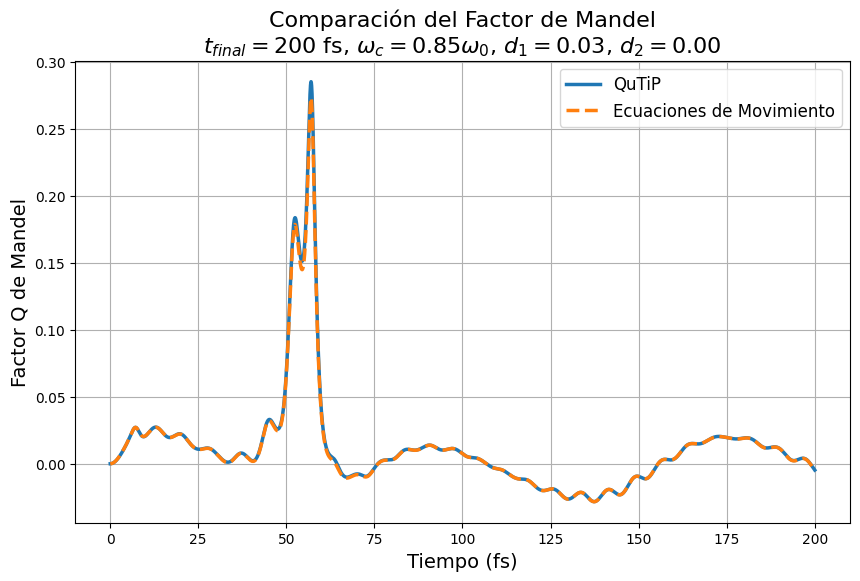

In [15]:

# ======================================================================
#                     BLOQUE PRINCIPAL DE EJECUCIÓN (BARRIDO)
# ======================================================================
if __name__ == "__main__":
    carpeta_salida = "Files_Optimization_J_Paper_I"
    os.makedirs(carpeta_salida, exist_ok=True)
    print(f"Las imágenes se guardarán en la carpeta: '{carpeta_salida}'")
    omega_0base = 2500 / au_cm1

    try:
        realizar_simulacion_y_optimización(
            t_final_fs=200,
            omega_c_valor=0.85 * omega_0base,
            omega_0base=omega_0base,
            carpeta_salida=carpeta_salida,
            f0_initial_factor=0.15,
            kappa_factor=0.0,
            Ub_factor=0.003,
            iteraciones=700
        )
        print(f"Corrida completada exitosamente.")

    except Exception as e:
        print(f"ERROR en la corrida  con los parámetros:")
        print(f"Error: {e}")
    print("\n¡Barrido de parámetros finalizado!")
